##  SMS Spam Classification

`Dataset Line` : https://www.kaggle.com/uciml/sms-spam-collection-dataset

This notebook is divided into 6 major steps which are as follows:

1. [Data Cleaning](#data-cleaning)
2. [EDA](#eda-pro)
3. [Text Processing](#text-processing)
4. [Model Building And Evaluation](#model-building)
5. [Model Improvement](#model-imp)
6. [Final Evaluation](#model-eval)

In [198]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7

In [280]:
import pandas as pd 
import numpy as np 
from pandas_profiling import ProfileReport

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report , f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier

import gzip, pickle
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\92304\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\92304\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
class ProjectClass:
    '''
    This class has number of methods for making the overall process 
    more effiecit by reusing the code.
    
    '''
    def __init__(self):
        pass
    def compare_models(self, models, X_train, y_train, X_val , y_val ):
        '''
        This method takes the dictionary of pre-defined dictionary of models along 
        with the respective dataframes to evaluate the model
        
        '''
        metrics_dict = {
            'acc_train' : [],
            'acc_val' : [],
            'precision_train' : [],
            'precision_val' : [],
            'recall' : [],
            'f1_score' : []
        }
        for i in models:

            model = models[i].fit(X_train, y_train)
            y_predicted_train =  model.predict(X_train)
            y_predicted =  model.predict(X_val)

            metrics_dict['acc_train'].append(round(accuracy_score(y_train, y_predicted_train),3))
            metrics_dict['acc_val'].append(round(accuracy_score(y_val,y_predicted),3))
            metrics_dict['precision_train'].append(round(precision_score(y_train, y_predicted_train),3))
            metrics_dict['precision_val'].append(round(precision_score(y_val, y_predicted),3))
            metrics_dict['recall'].append(round(recall_score(y_val, y_predicted),3))
            metrics_dict['f1_score'].append(round(f1_score(y_val, y_predicted),3))
            
        return pd.DataFrame(metrics_dict, index= models.keys()).sort_values(by='precision_val', ascending=False)
    
    def get_data(self, X, y, max_features=None):
        if max_features:
            tfv = TfidfVectorizer(max_features=max_features)
            X = (tfv.fit_transform(df.transformed_text)).toarray()
            X_train, X_test , y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)
            return X_train, X_test, y_train, y_test
        else : 
            tfv = TfidfVectorizer()
            X = (tfv.fit_transform(df.transformed_text)).toarray()
            X_train, X_test , y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)
            return X_train, X_test, y_train, y_test
    def plot_coef(self, classifier,X_train, y_train):
        '''
        This method takes a single classifier along with the X_train and y_train and will returns the plot of model coefficients
        
        '''
        classifier.fit(X_train, y_train)
        weights = classifier.coef_
        weights = np.array(weights).flatten()
        weights_df = pd.DataFrame({
            'columns': X_train.columns,
            'weight': weights
        }).sort_values('weight', ascending=False)
        weights_df["abs_value"] = weights_df["weight"].apply(lambda x: abs(x))
        weights_df["colors"] = weights_df["weight"].apply(lambda x: "green" if x > 0 else "red")
        weights_df = weights_df.sort_values("abs_value", ascending=False)

        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        sns.barplot(x="columns",
                    y="weight",
                    data=weights_df.head(30),
                   palette=weights_df.head(30)["colors"])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
        ax.set_ylabel("Coef", fontsize=20)
        ax.set_xlabel("Feature Name", fontsize=20);
    
    def plot_cm(self,y_val, y_predicted):
        '''
        This method takes true y values and predicted y values to draw a Confusion Matrix
        
        '''
        conf_matrix = confusion_matrix(y_val,y_predicted)
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
    def plot_auc_curve(self,classifiers, X_train, y_train, X_val, y_val):
        '''
        This method will takes a list of classifiers, X_train, y_train, X_val and y_val. 
        It will return the AUC Curves for each the model provided in the input list.
        
        '''
        result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

        for cls in classifiers:
            model = cls.fit(X_train, y_train)
            yproba = model.predict_proba(X_val)[::,1]

            fpr, tpr, _ = roc_curve(y_val,  yproba)
            auc = roc_auc_score(y_val, yproba)

            result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                                'fpr':fpr, 
                                                'tpr':tpr, 
                                                'auc':auc}, ignore_index=True)

        result_table.set_index('classifiers', inplace=True)

        fig = plt.figure(figsize=(8,6))

        for i in result_table.index:
            plt.plot(result_table.loc[i]['fpr'], 
                     result_table.loc[i]['tpr'], 
                     label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

        plt.plot([0,1], [0,1], color='orange', linestyle='--')

        plt.xticks(np.arange(0.0, 1.1, step=0.1))
        plt.xlabel("Flase Positive Rate", fontsize=15)
        plt.yticks(np.arange(0.0, 1.1, step=0.1))
        plt.ylabel("True Positive Rate", fontsize=15)
        plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
        plt.legend(prop={'size':13}, loc='lower right')
        plt.show()

In [201]:
df = pd.read_csv('spam.csv')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## 1. Data Cleaning<a id='data-cleaning'></a>

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [203]:
#Drop last 3 cols
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace= True)

In [204]:
df.sample(5)

,v1,v2
1106,ham,"Good afternoon, my love. How goes your day ? W..."
2770,ham,No problem. Talk to you later
4726,spam,Had your mobile 10 mths? Update to the latest ...
1360,ham,Yo dude guess who just got arrested the other day
1510,ham,"Pete,is this your phone still? Its Jenny from ..."


In [205]:
# Renaming the cols 
df.rename(columns={'v1':'Target', 'v2':'Text'}, inplace=True)
df.sample(3)

,Target,Text
5238,ham,Yeah I can still give you a ride
3343,ham,Oh great. I.ll disturb him more so that we can...
1228,spam,FREE entry into our �250 weekly comp just send...


In [206]:
df['Target'] = df.Target.replace(to_replace=['ham', 'spam'], value=[0,1])
df.Target.value_counts()

0    4825
1     747
Name: Target, dtype: int64

In [207]:
# Missing Values
df.isna().sum()

Target    0
Text      0
dtype: int64

In [208]:
#Check for Duplicate Records
df.duplicated().sum()

403

In [209]:
#Remove Duplicate Records
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

## 2. EDA<a id='eda-pro'></a>

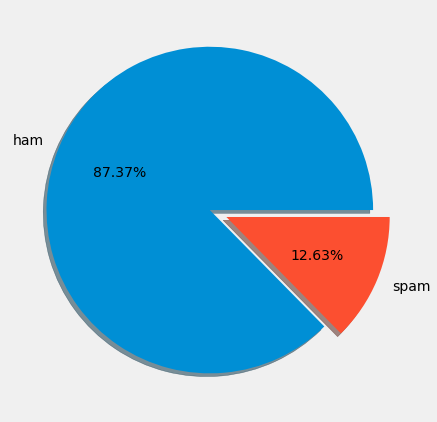

In [210]:
plt.pie(df.Target.value_counts(), labels=['ham', 'spam'], autopct='%0.2f%%', explode=[.01,.1],shadow =True);

**It shows that the data is imbalance**

In [211]:
df['num_characters'] = df['Text'].apply(len)
df.head(3)

,Target,Text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155


In [212]:
#Number of words
df['num_words'] = df['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head(3)

,Target,Text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37


In [213]:
#Number of sentences 
df['num_sentences'] = df['Text'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head(3)

,Target,Text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2


In [214]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,5169.0,0.126330,0.332253,0.0,0.0,0.0,0.0,1.0
num_characters,5169.0,78.923776,58.174846,2.0,36.0,60.0,117.0,910.0
num_words,5169.0,18.456375,13.323322,1.0,9.0,15.0,26.0,220.0
num_sentences,5169.0,1.962275,1.433892,1.0,1.0,1.0,2.0,38.0


In [215]:
#Description of ham messages
df[df['Target']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
Target,4516.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
num_characters,4516.0,70.456820,56.356802,2.0,34.0,52.0,90.0,910.0
num_words,4516.0,17.123339,13.491315,1.0,8.0,13.0,22.0,220.0
num_sentences,4516.0,1.815545,1.364098,1.0,1.0,1.0,2.0,38.0


In [216]:
#Description of spam messages
df[df['Target']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
Target,653.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
num_characters,653.0,137.479326,30.014336,13.0,131.0,148.0,157.0,223.0
num_words,653.0,27.675345,7.011513,2.0,25.0,29.0,32.0,46.0
num_sentences,653.0,2.977029,1.493676,1.0,2.0,3.0,4.0,9.0


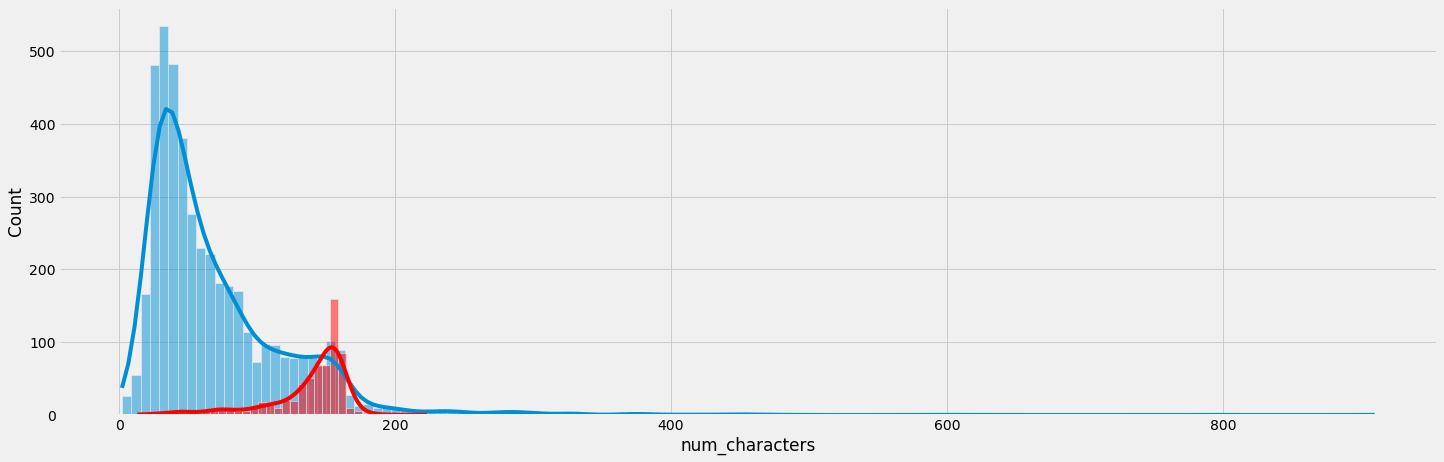

In [217]:
sns.histplot(df[df['Target']==0]['num_characters'], kde=True)
sns.histplot(df[df['Target']==1]['num_characters'], kde=True, color='red');

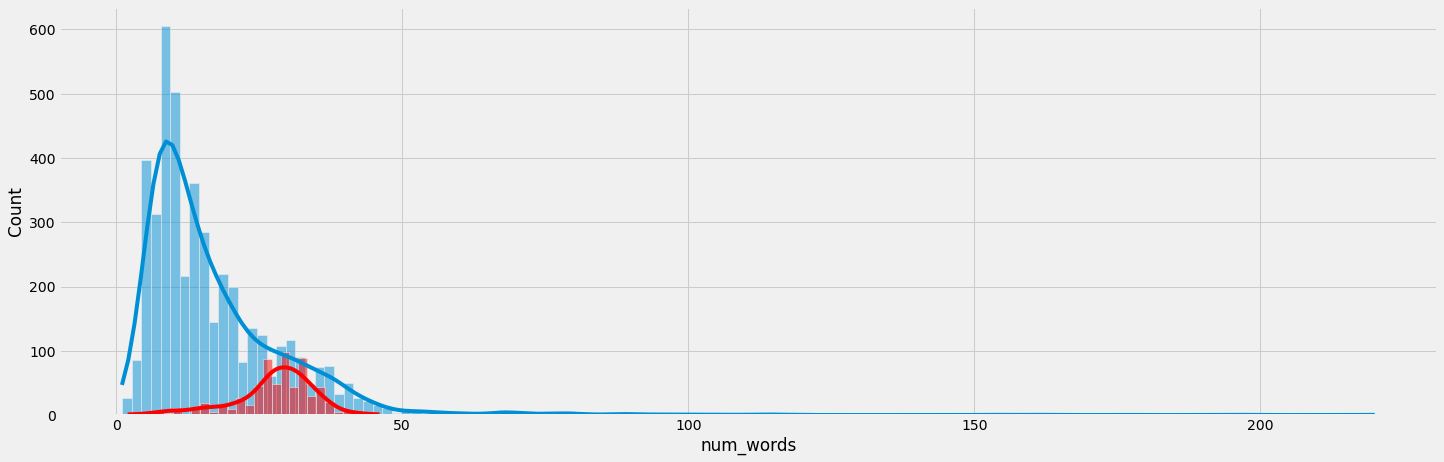

In [218]:
sns.histplot(df[df['Target']==0]['num_words'], kde=True)
sns.histplot(df[df['Target']==1]['num_words'], kde=True, color='red');

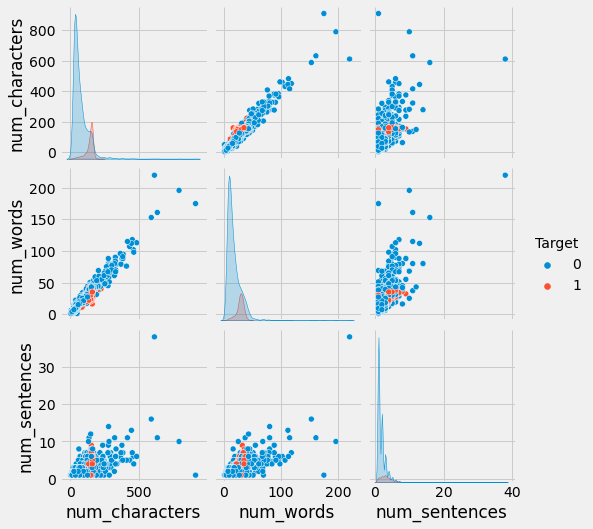

In [219]:
sns.pairplot(df, hue='Target');

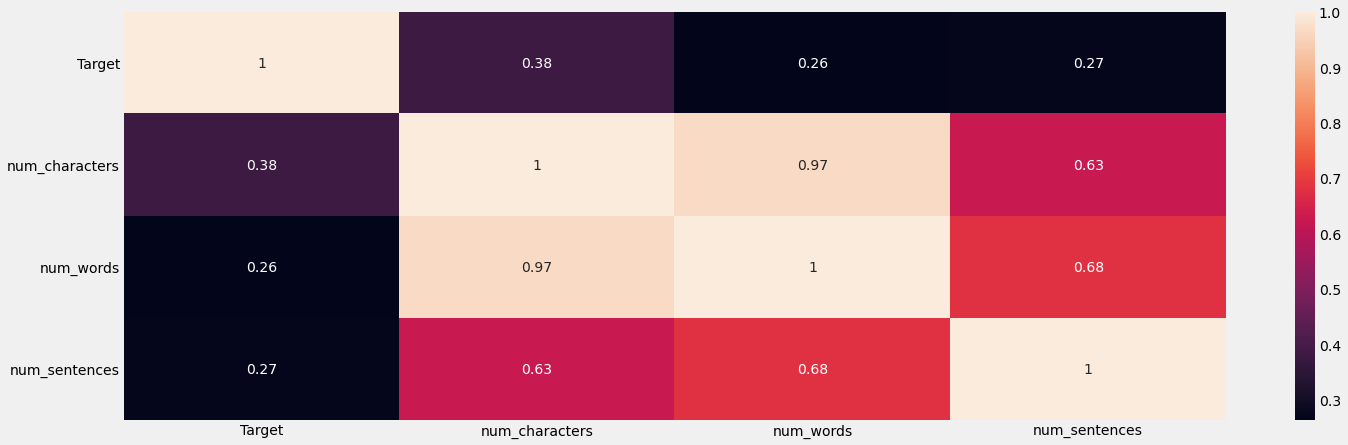

In [220]:
sns.heatmap(df.corr(), annot=True);

We are going to select ``num_charaters``(high correlation with target) from last 3 columns as they have multicollinearity 

## 3. Text Processing<a id='text-processing'></a>

In [221]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [PorterStemmer().stem(i) for i in text if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation]
    return " ".join(text)

In [222]:
df['transformed_text'] = df.Text.apply(transform_text)
df.head(3)

,Target,Text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...


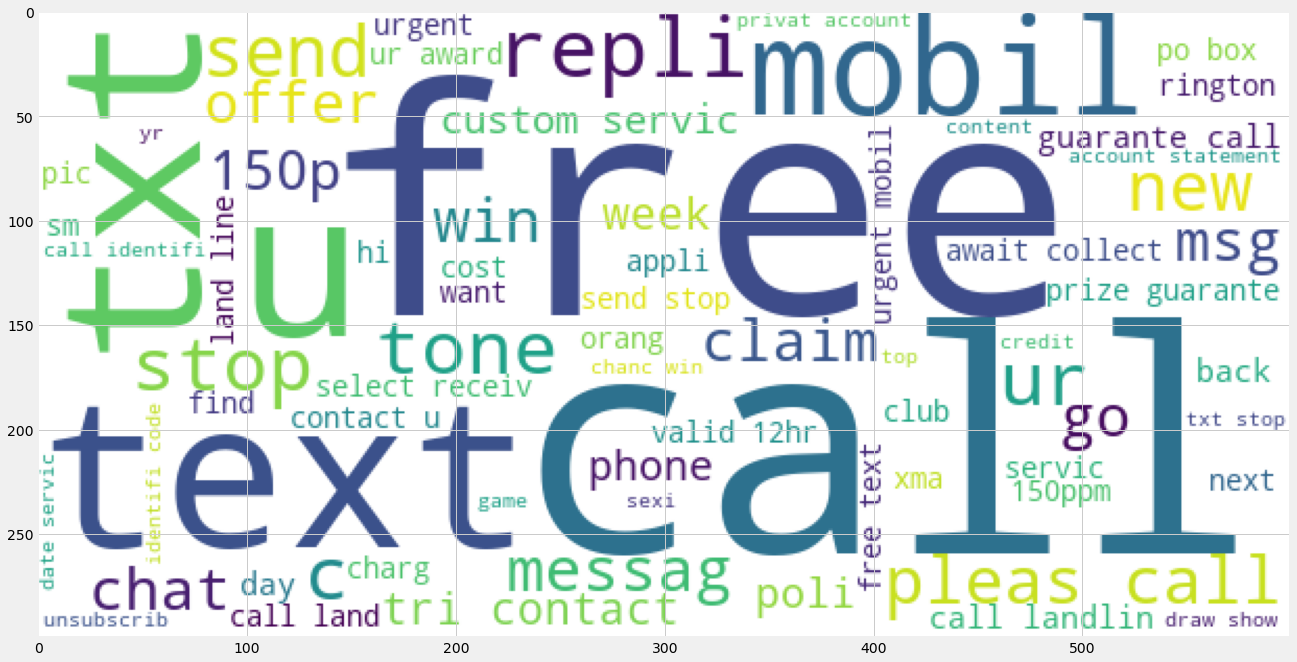

In [223]:
#Wordcloud spam
plt.figure(figsize=(20,15))
wc = WordCloud(width=600, height=300, min_font_size=10, background_color = 'white')
spam_wc = wc.generate(df[df['Target']==1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc);

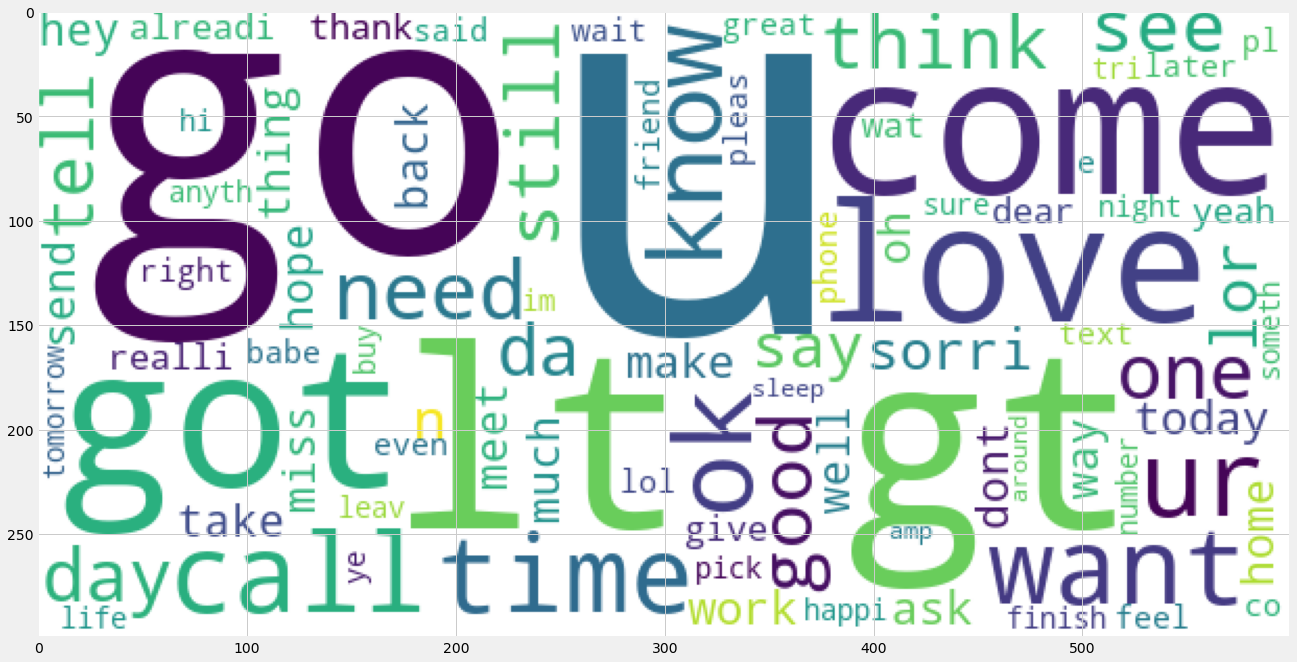

In [224]:
#Wordcloud ham
plt.figure(figsize=(20,15))
wc = WordCloud(width=600, height=300, min_font_size=10, background_color = 'white')
ham_wc = wc.generate(df[df['Target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc);

In [225]:
spam_corpus = [word for msg in df[df['Target']==1]['transformed_text'].tolist() for word in msg.split()]
print(len(spam_corpus))
spam_corpus[0:5]

9941


['free', 'entri', '2', 'wkli', 'comp']

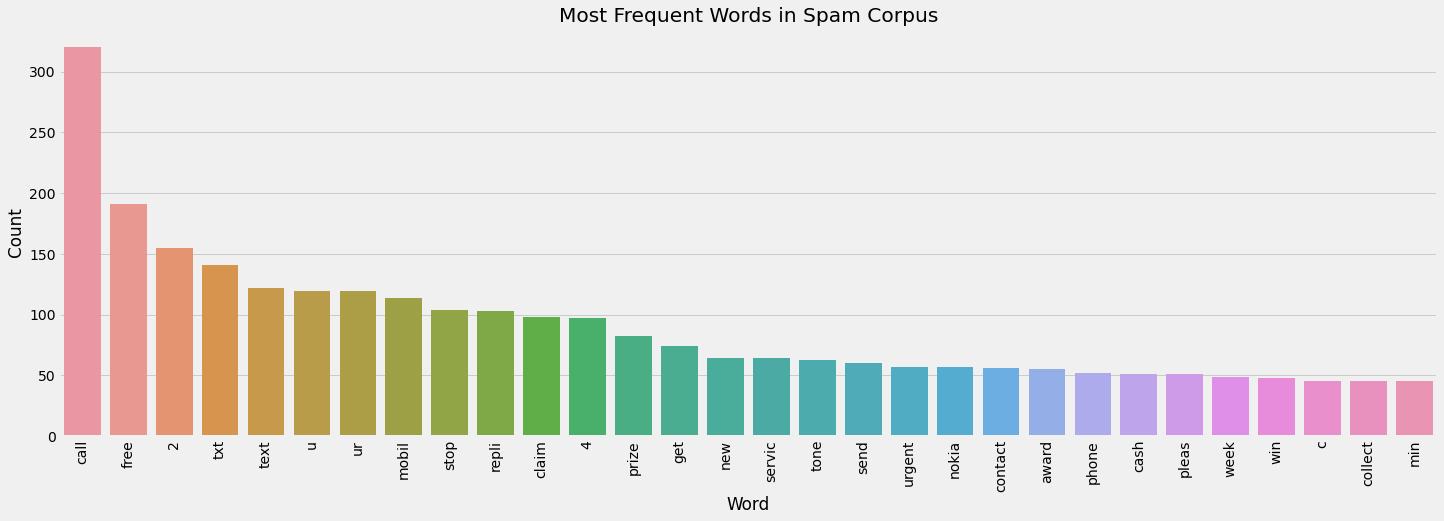

In [226]:
#Top 30 most occuring words in spam
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Frequent Words in Spam Corpus');

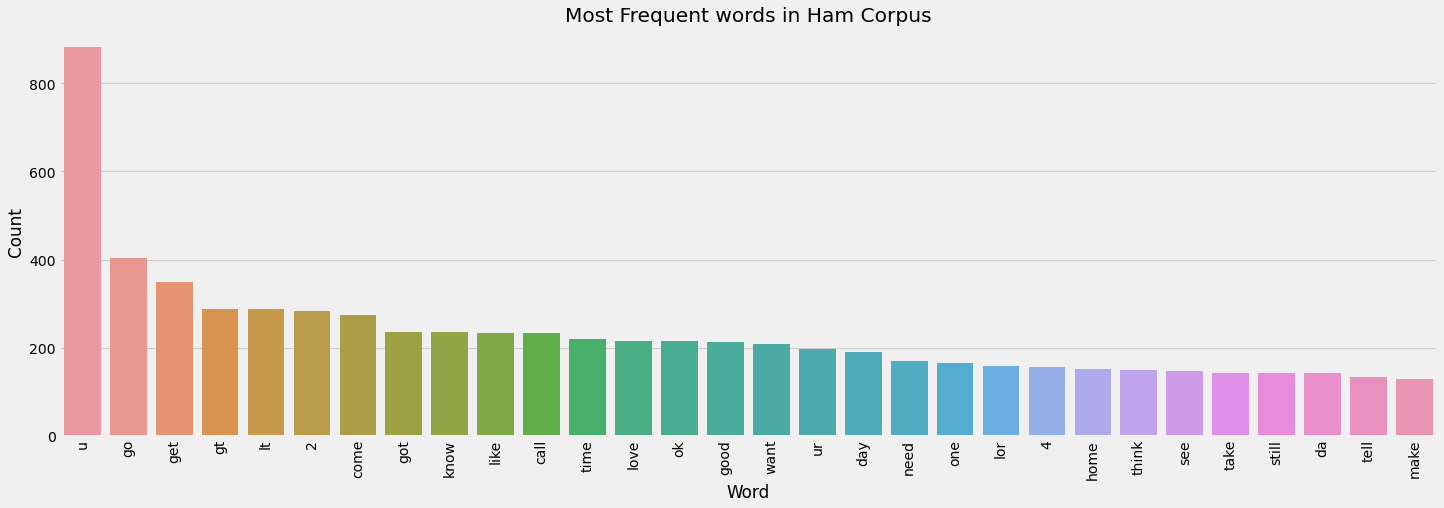

In [227]:
#Top 30 most frequent words in ham
ham_corpus = [word for msg in df[df['Target']==0]['transformed_text'].tolist() for word in msg.split()]
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Frequent words in Ham Corpus');

## 4. Model Building And Evaluation<a id='model-building'></a>

In [228]:
tfv = TfidfVectorizer()
X = (tfv.fit_transform(df.transformed_text)).toarray()
print(X.shape)
X[0:3,:]

(5169, 6677)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [229]:
y = df.Target.values
y.shape

(5169,)

In [230]:
X_train, X_test , y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((4135, 6677), (4135,), (1034, 6677), (1034,))

In [231]:
#As we are not sure about the data distribution for now so we are going to use all three Naive Bayes Models 
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [232]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred1)}")
print(f"Precision : {precision_score(y_test, y_pred1)}")
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy : 0.874274661508704
Precision : 0.518348623853211
[[791 105]
 [ 25 113]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       896
           1       0.52      0.82      0.63       138

    accuracy                           0.87      1034
   macro avg       0.74      0.85      0.78      1034
weighted avg       0.91      0.87      0.89      1034



**The focused metrics here is ``precision``, which is not doind well with this model**

In [233]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred2)}")
print(f"Precision : {precision_score(y_test, y_pred2)}")
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy : 0.9593810444874274
Precision : 1.0
[[896   0]
 [ 42  96]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       896
           1       1.00      0.70      0.82       138

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



In [234]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred3)}")
print(f"Precision : {precision_score(y_test, y_pred3)}")
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy : 0.971953578336557
Precision : 0.9823008849557522
[[894   2]
 [ 27 111]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       896
           1       0.98      0.80      0.88       138

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



**Here, We would go with ``MultinomialNB`` as it giving the ``100%`` Accuracy Score**

In [235]:
ps = ProjectClass()

In [236]:
classifiers = {
    'svc' : SVC(kernel='sigmoid', gamma=1.0),
    'knc' : KNeighborsClassifier(),  
    'mnb' : MultinomialNB(),
    'dtc' : DecisionTreeClassifier(max_depth=5),
    'lrc' : LogisticRegression(solver='liblinear', penalty='l1'),
    'rfc' : RandomForestClassifier(n_estimators=50, random_state=2),
    'abc' : AdaBoostClassifier(n_estimators=50, random_state=2),
    'bc'  : BaggingClassifier(n_estimators=50, random_state=2),
    'etc' : ExtraTreesClassifier(n_estimators=50, random_state=2),
    'gbdt': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'xgb' : XGBClassifier(n_estimators=50, random_state=2)
}

In [237]:
comparison0 = ps.compare_models(models=classifiers, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test)
comparison0

[12:52:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,acc_train,acc_val,precision_train,precision_val,recall,f1_score
knc,0.919,0.900,1.000,1.000,0.254,0.405
mnb,0.971,0.959,1.000,1.000,0.696,0.821
rfc,1.000,0.970,1.000,0.991,0.783,0.874
etc,1.000,0.978,1.000,0.991,0.841,0.910
svc,0.986,0.973,0.985,0.974,0.819,0.890
abc,0.975,0.962,0.964,0.954,0.754,0.842
xgb,0.985,0.972,0.993,0.950,0.833,0.888
lrc,0.961,0.952,0.954,0.940,0.681,0.790
gbdt,0.966,0.952,0.995,0.931,0.688,0.792
bc,1.000,0.957,1.000,0.862,0.812,0.836


## 5. Model Improvement<a id='model-imp'></a>

In [238]:
#Choosing the max_features = 3000 for tfidfVectorizer
X_train1, X_test1, y_train1, y_test1 =  ps.get_data(X, y, max_features=3000)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((4135, 3000), (1034, 3000), (4135,), (1034,))

In [239]:
comparison1 = ps.compare_models(models=classifiers, X_train=X_train1, y_train=y_train1, X_val=X_test1, y_val=y_test1)
comparison1

[12:55:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,acc_train,acc_val,precision_train,precision_val,recall,f1_score
knc,0.926,0.905,1.000,1.000,0.290,0.449
mnb,0.979,0.972,0.995,1.000,0.790,0.883
rfc,1.000,0.976,1.000,0.983,0.833,0.902
etc,1.000,0.980,1.000,0.976,0.870,0.920
svc,0.984,0.975,0.983,0.975,0.833,0.898
lrc,0.964,0.956,0.951,0.970,0.696,0.810
abc,0.971,0.961,0.956,0.945,0.754,0.839
xgb,0.984,0.968,1.000,0.934,0.819,0.873
gbdt,0.967,0.947,0.992,0.928,0.652,0.766
bc,0.999,0.959,0.998,0.869,0.819,0.843


In [242]:
comparison_with_max_features = pd.merge(comparison0[['acc_val', 'precision_val']], comparison1[['acc_val', 'precision_val']],
                                        left_index=True, right_index=True, suffixes=('', '_max_3000_ft'))
comparison_with_max_features

,acc_val,precision_val,acc_val_max_3000_ft,precision_val_max_3000_ft
knc,0.900,1.000,0.905,1.000
mnb,0.959,1.000,0.972,1.000
rfc,0.970,0.991,0.976,0.983
etc,0.978,0.991,0.980,0.976
svc,0.973,0.974,0.975,0.975
abc,0.962,0.954,0.961,0.945
xgb,0.972,0.950,0.968,0.934
lrc,0.952,0.940,0.956,0.970
gbdt,0.952,0.931,0.947,0.928
bc,0.957,0.862,0.959,0.869


In [267]:
#Let's Check if the scalling can help us in achiving the better score
X_scaled = MinMaxScaler().fit_transform(X) # We didn't use the Standard Scaler here because it might give the -ve values and Naive Bayes doesn't work the -ve values
X_train2, X_test2, y_train2, y_test2 =  ps.get_data(X_scaled, y, max_features=3000)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((4135, 3000), (1034, 3000), (4135,), (1034,))

In [246]:
comparison2 = ps.compare_models(models=classifiers, X_train=X_train2, y_train=y_train2, X_val=X_test2, y_val=y_test2)
comparison2

[13:03:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,acc_train,acc_val,precision_train,precision_val,recall,f1_score
knc,0.926,0.905,1.000,1.000,0.290,0.449
mnb,0.979,0.972,0.995,1.000,0.790,0.883
rfc,1.000,0.976,1.000,0.983,0.833,0.902
etc,1.000,0.980,1.000,0.976,0.870,0.920
svc,0.984,0.975,0.983,0.975,0.833,0.898
lrc,0.964,0.956,0.951,0.970,0.696,0.810
abc,0.971,0.961,0.956,0.945,0.754,0.839
xgb,0.984,0.968,1.000,0.934,0.819,0.873
gbdt,0.967,0.947,0.992,0.928,0.652,0.766
bc,0.999,0.959,0.998,0.869,0.819,0.843


In [249]:
complete_comparision = pd.merge(comparison_with_max_features, comparison2[['acc_val', 'precision_val']], left_index = True, right_index=True, suffixes=('', '_3000_ft_scaled'))
complete_comparision

,acc_val,precision_val,acc_val_max_3000_ft,precision_val_max_3000_ft,acc_val_3000_ft_scaled,precision_val_3000_ft_scaled
knc,0.900,1.000,0.905,1.000,0.905,1.000
mnb,0.959,1.000,0.972,1.000,0.972,1.000
rfc,0.970,0.991,0.976,0.983,0.976,0.983
etc,0.978,0.991,0.980,0.976,0.980,0.976
svc,0.973,0.974,0.975,0.975,0.975,0.975
abc,0.962,0.954,0.961,0.945,0.961,0.945
xgb,0.972,0.950,0.968,0.934,0.968,0.934
lrc,0.952,0.940,0.956,0.970,0.956,0.970
gbdt,0.952,0.931,0.947,0.928,0.947,0.928
bc,0.957,0.862,0.959,0.869,0.959,0.869


In [285]:
#Add "num_characters" column in the model 
tfidf = TfidfVectorizer(max_features=3000)
tfidf.fit_transform(df['transformed_text']).toarray()
X = tfidf.fit_transform(df['transformed_text']).toarray()
X = np.hstack((X, df['num_characters'].values.reshape(-1,1)))
X.shape

(5169, 3001)

In [270]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=2)
comparison3 = ps.compare_models(models=classifiers, X_train=X_train3, y_train=y_train3, X_val=X_test3, y_val=y_test3)
complete_comparision_1 = pd.merge(complete_comparision, comparison3[['acc_val', 'precision_val']], left_index = True, right_index=True, suffixes=('', '_3000_ft_num_characters'))
complete_comparision_1

[13:56:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,acc_val,precision_val,acc_val_max_3000_ft,precision_val_max_3000_ft,acc_val_3000_ft_scaled,precision_val_3000_ft_scaled,acc_val_3000_ft_num_characters,precision_val_3000_ft_num_characters
knc,0.900,1.000,0.905,1.000,0.905,1.000,0.918,0.715
mnb,0.959,1.000,0.972,1.000,0.972,1.000,0.961,0.922
rfc,0.970,0.991,0.976,0.983,0.976,0.983,0.972,0.936
etc,0.978,0.991,0.980,0.976,0.980,0.976,0.965,0.892
svc,0.973,0.974,0.975,0.975,0.975,0.975,0.867,0.000
abc,0.962,0.954,0.961,0.945,0.961,0.945,0.965,0.918
xgb,0.972,0.950,0.968,0.934,0.968,0.934,0.972,0.950
lrc,0.952,0.940,0.956,0.970,0.956,0.970,0.967,0.948
gbdt,0.952,0.931,0.947,0.928,0.947,0.928,0.953,0.932
bc,0.957,0.862,0.959,0.869,0.959,0.869,0.957,0.826


So the final selection is ``MultinomialNB`` with ``max_features=3000``                                                         

In [275]:
# Voting Classifier with the best performing models
voting = VotingClassifier(estimators=[
    ('svm' , SVC(kernel='sigmoid', gamma=1.0, probability=True)),
    ('nb'  , MultinomialNB()),
    ('etc' , ExtraTreesClassifier(n_estimators=50, random_state=2))
], voting='soft')
voting.fit(X_train1, y_train1)
y_pred1 = voting.predict(X_test1)
print(f"Accuracy : {accuracy_score(y_test1, y_pred1)}")
print(f"Precision : {precision_score(y_test1, y_pred1)}")
print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

Accuracy : 0.9825918762088974
Precision : 0.9918032786885246
[[895   1]
 [ 17 121]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       896
           1       0.99      0.88      0.93       138

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [276]:
#Applying Stacking
stacking = StackingClassifier(estimators=[
    ('svm' , SVC(kernel='sigmoid', gamma=1.0, probability=True)),
    ('nb'  , MultinomialNB()),
    ('etc' , ExtraTreesClassifier(n_estimators=50, random_state=2))
], final_estimator=RandomForestClassifier())
stacking.fit(X_train1, y_train1)
y_pred1 = stacking.predict(X_test1)
print(f"Accuracy : {accuracy_score(y_test1, y_pred1)}")
print(f"Precision : {precision_score(y_test1, y_pred1)}")
print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

Accuracy : 0.97678916827853
Precision : 0.9253731343283582
[[886  10]
 [ 14 124]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       896
           1       0.93      0.90      0.91       138

    accuracy                           0.98      1034
   macro avg       0.95      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



Voting and Stacking Could not give the best result on ``precision`` so We would go with the ``MultinomialNB``

In [283]:
mnb = MultinomialNB()
mnb.fit(X_train1, y_train1)
y_pred1 = mnb.predict(X_test1)
print(f"Accuracy : {accuracy_score(y_test1, y_pred1)}")
print(f"Precision : {precision_score(y_test1, y_pred1)}")
print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

Accuracy : 0.971953578336557
Precision : 1.0
[[896   0]
 [ 29 109]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       896
           1       1.00      0.79      0.88       138

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



In [286]:
with gzip.open('vectorizer.pickle.gz', 'wb') as f:
    pickle.dump(tfidf, f)
with gzip.open('model.pickle.gz', 'wb') as f :
    pickle.dump(mnb, f)

In [287]:
with gzip.open("vectorizer.pickle.gz", 'rb') as f:
    tfidf = pickle.load(f)
with gzip.open("model.pickle.gz", 'rb') as f:
    model = pickle.load(f)